<a href="https://colab.research.google.com/github/anhduong77/CustomerSatisfaction/blob/main/notebook/4_Casual_inference_%26%26_data_storytelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/CustomerSatisfaction/archive/cleaned_data.csv")

In [ ]:
df.head()

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_zip_code_prefix,customer_city,customer_state,...,seller_lat,seller_lng,total_items,total_price,total_freight,review_score,total_payment_value,distance_km,late_delivery,dissatisfied
0,Other,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3149,sao paulo,SP,...,-23.680729,-46.444238,1.0,29.99,8.72,4,38.71,18.576110,0,0
1,Other,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,47813,Other,BA,...,-19.807681,-43.980427,1.0,118.70,22.76,4,141.46,851.495069,0,0
2,Other,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,75265,Other,GO,...,-21.363502,-48.229601,1.0,159.90,19.22,5,179.12,514.410666,0,0
3,Other,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00,59296,Other,Other,...,-19.837682,-43.924053,1.0,45.00,27.20,5,72.20,1822.226336,0,0
4,Other,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00,9195,Other,SP,...,-23.543395,-46.262086,1.0,19.90,8.72,5,28.62,29.676625,0,0


# 1. Casual Inference

In [ ]:
covariates = [
    'customer_city', 'customer_state',
    'seller_city', 'seller_state',
    'total_price', 'total_freight', 'distance_km'
]

In [ ]:
X = pd.get_dummies(df[covariates], drop_first=True)
dummy_cols = X.columns.difference(["total_price", "total_freight"])
X[dummy_cols] = X[dummy_cols].astype(int)

T = df['late_delivery'].values
Y = df['dissatisfied'].values

In [ ]:
!pip install econml -q >> /dev/nul
from econml.dr import LinearDRLearner
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [ ]:
est = LinearDRLearner(
    model_regression=RandomForestRegressor(min_samples_leaf=20),
    model_propensity=RandomForestClassifier(min_samples_leaf=20),
    min_propensity=0.01
)

est.fit(Y, T, X=X)

# Check the result again
ate = est.ate(X).mean()
print(f"Average ATE: {ate}")

Average ATE: 0.42370311172370645


# 2. Impact Analysis Global Impact:
- Late delivery is the single largest driver of dissatisfaction, increasing the risk of a bad review by **42.37 percentage points**.

- **Segment Analysis**: To make this actionable, we cannot treat all customers the same. Below, we break down this impact to identify our "At-Risk" segments. We need to know: does the value of the product ($) make the customer less forgiving of logistics failures?

/tmp/ipython-input-1035401949.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tier_analysis, x='distance_segment', y='impact_on_satisfaction', palette="Reds")


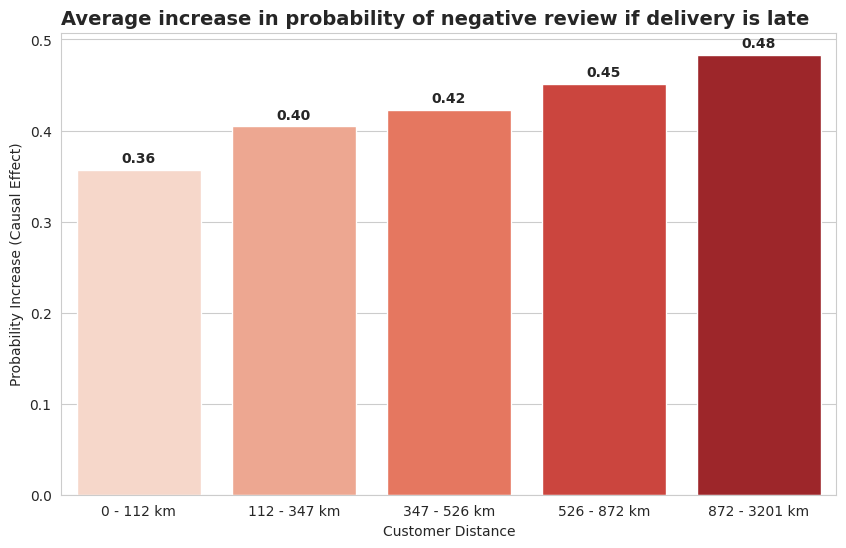

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


individual_effects = est.effect(X)
df['impact_on_satisfaction'] = individual_effects

_, bins = pd.qcut(df['distance_km'], q=5, retbins=True)

labels = [f"{int(bins[i])} - {int(bins[i+1])} km" for i in range(len(bins)-1)]


df['distance_segment'] = pd.cut(df['distance_km'], bins=bins, labels=labels, include_lowest=True)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

tier_analysis = df.groupby('distance_segment', observed=False)['impact_on_satisfaction'].mean().reset_index()


ax = sns.barplot(data=tier_analysis, x='distance_segment', y='impact_on_satisfaction', palette="Reds")


for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3, fontweight='bold')


plt.title("Average increase in probability of negative review if delivery is late", fontsize=14, fontweight='bold', loc='left')
plt.ylabel("Probability Increase (Causal Effect)", fontsize=10)
plt.xlabel("Customer Distance", fontsize=10)

plt.show()

The Data: The sensitivity to **late delivery is 12%** higher for customers in the longest-distance segment compared to those in the shortest-distance segment.

/tmp/ipython-input-844425246.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=tier_analysis, x='customer_city', y='impact_on_satisfaction', palette="Reds")


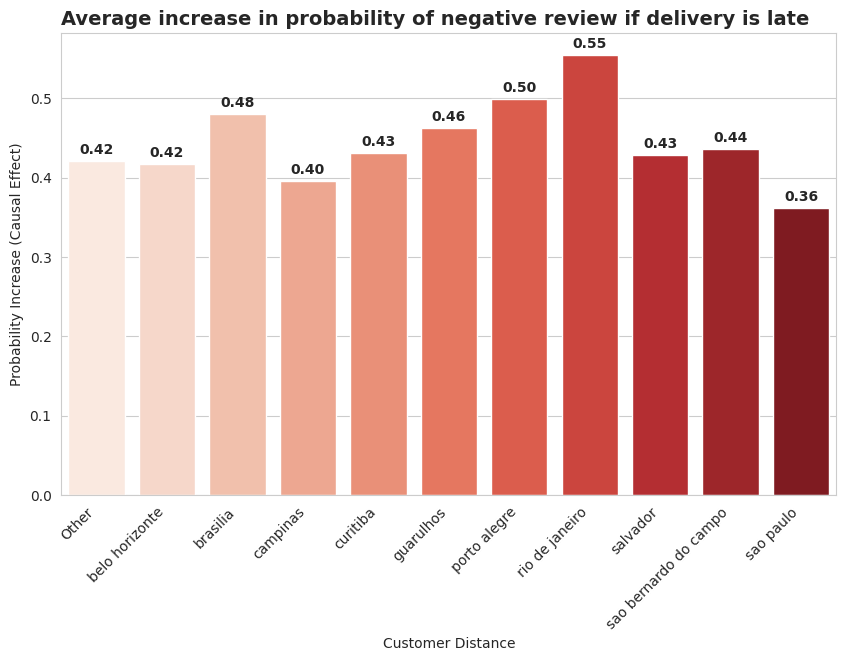

In [ ]:
df['freight_segment'] = pd.cut(df['total_freight'], bins=bins, labels=labels, include_lowest=True)
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

tier_analysis = df.groupby('customer_city', observed=False)['impact_on_satisfaction'].mean().reset_index()


ax = sns.barplot(data=tier_analysis, x='customer_city', y='impact_on_satisfaction', palette="Reds")


for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3, fontweight='bold')


plt.title("Average increase in probability of negative review if delivery is late", fontsize=14, fontweight='bold', loc='left')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Probability Increase (Causal Effect)", fontsize=10)
plt.xlabel("Customer Distance", fontsize=10)

plt.show()

- The city that is leas affected by late delivery is sao paulo, since this is the center city so logistic in here quite quick and fast
- The city that is mostly affected by late delivery is rio de janeiro, so now let inspect the reason why

In [ ]:
# 1. Filter for the specific "Golden Route" (SP -> RJ)
# We use State codes because they are cleaner in the dataset
route_mask = (df['seller_state'] == 'SP') & (df['customer_state'] == 'RJ')

# 2. Calculate the Distance
# We take the mean because specific zip codes vary slightly
avg_distance_sp_rj = df[route_mask]['distance_km'].mean()

print(f"--- DISTANCE ANALYSIS ---")
print(f"Average Distance from SP to RJ: {avg_distance_sp_rj:.2f} km")
print("-" * 30)

# 3. Compare Late Delivery Rates
# We classify every order into two groups: "SP->RJ" and "The Rest of Brazil"
df['route_type'] = df.apply(lambda x: 'SP -> RJ' if (x['seller_state'] == 'SP' and x['customer_state'] == 'RJ') else 'Rest of Brazil', axis=1)

# Calculate the stats
route_stats = df.groupby('route_type')['late_delivery'].agg(['count', 'mean']).reset_index()
route_stats.columns = ['Route', 'Total Orders', 'Late %']

print(route_stats)

--- DISTANCE ANALYSIS ---
Average Distance from SP to RJ: 440.56 km
------------------------------
            Route  Total Orders    Late %
0  Rest of Brazil         90350  0.071123
1        SP -> RJ          8323  0.148504


/tmp/ipython-input-2967031623.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=route_stats, x='Route', y='Late %', palette=['gray', 'red'])


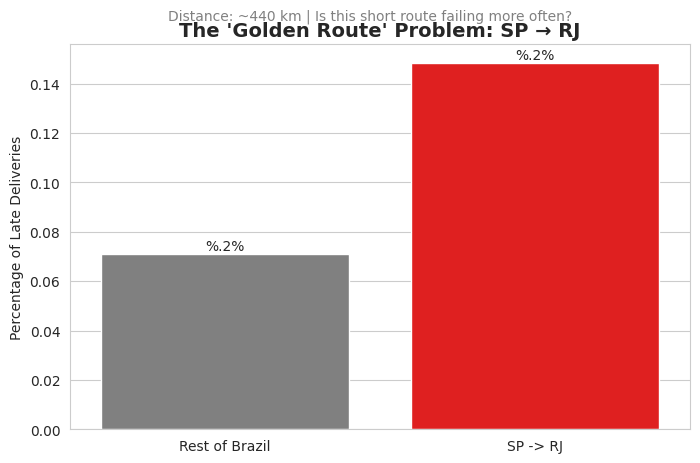

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))

# Plot the comparison
ax = sns.barplot(data=route_stats, x='Route', y='Late %', palette=['gray', 'red'])

# Add Percentage Labels
for i in ax.containers:
    ax.bar_label(i, fmt='%.2%')

# Storytelling Titles
plt.title("The 'Golden Route' Problem: SP → RJ", fontsize=14, fontweight='bold')
plt.suptitle(f"Distance: ~{int(avg_distance_sp_rj)} km | Is this short route failing more often?", y=0.95, fontsize=10, color='gray')
plt.ylabel("Percentage of Late Deliveries")
plt.xlabel("")

plt.show()

# Summary:
The "Golden Route" Paradox Our analysis traces the highest concentration of late shipments to the São Paulo → Rio de Janeiro route. Despite connecting Brazil's two largest economic hubs (a short distance), this corridor suffers from a disproportionately high rate of customer dissatisfaction.

The Root Cause: The data suggests a systematic underestimation of delivery times. Our current prediction model relies heavily on linear geography (distance in km) while ignoring operational friction (traffic congestion and urban complexity). Since this is the busiest logistics artery in the country, "Distance" is a poor predictor of "Time."

Actionable Insights:

    Algorithmic Padding: Update the prediction engine to add a +2 Day Safety Buffer specifically for the SP → RJ route to account for congestion.

    Proactive Customer Care: Instead of reactive compensation (which is costly), trigger automated "Traffic Alert" emails to manage expectations before the delivery becomes late.